In [1]:
# Selecting libraries
import yfinance as yf
import pandas as pd
import numpy as np
import pyfolio as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings("ignore")
import re
import cvxopt as opt
from cvxopt import blas, solvers
pd.set_option('display.max_columns', 500)

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, objective_functions
from pypfopt import expected_returns

/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


## What happened here
In this script we tested how we could use forecasted covariance matrices to build portfolios
Issues:
+ we took the square root of the variance, when it should be the square.
+ We took the monthly variance, but the mean value we used in the efficeint frontier was daily returns.
+ I also noted that risk_models.samplecovariance spits out annulaised daily returns always
+ The input volatility data was annulaised daily variance. we get this by multilplying by $ var * \sqrt{252} $
+ we then converted this to monthly by: $ var *(\sqrt{21} / \sqrt{252}) $
+ We had issues whereby the matrix forecasted is not PSD, we fixed this by introducing regulrizastion and zeroing the eigenvalues. 
  I want to find out why this is happening. i would hope regularizing alone would have fixed the issue.

In [2]:
# Define the assets and key initial metrics as investment amount to generate a portfolio

stocks = ['DHR','GILD','ISRG','JNJ','LLY','PFE','REGN','TMO','AZN','MRK']
portfolio_value = 10**6                         # Initial Portfolio Value to be allocated in full
weights = [1/len(stocks)]*len(stocks)         # Weight Allocation per asset

benchmark = '^GSPC'                    # Which is your benchmark? ^GSPC is SP500 for Yfinance library

start_date = '2009-01-01'              # Start date for asset data download
live_date = '2015-01-01'               # Portfolio LIVE start date (for analytics)


# Warning handling
if len(weights) != len(stocks):
    print(sum((np.array(weights))))
    print('Number of Asset does not match weight allocated')
    
weight = round(sum((np.array(weights))))
if weight != 1.0:
    print(sum((np.array(weights))))
    print('Weight could not be allocated properly, make sure they sum 1.0')


In [3]:
# Download data, clean and isolate values for calculation
# If you use other data source, make sure the format is the same than stock_data.head() on next cell. Check dtypes by stock_data.info()

stock_data = yf.download(stocks, start=start_date)['Adj Close']
stock_data = stock_data.dropna()
stock_data = stock_data.reindex(columns=stocks)
stock_prices = stock_data[stocks].values

[*********************100%***********************]  10 of 10 completed


In [4]:
shares_df = pd.DataFrame(index=[stock_data.index[0]])

for s,w in zip(stocks, weights):
    shares_df[s + '_shares'] = np.floor((portfolio_value * np.array(w)) / stock_data[s][0])

shares_df    

,DHR_shares,GILD_shares,ISRG_shares,JNJ_shares,LLY_shares,PFE_shares,REGN_shares,TMO_shares,AZN_shares,MRK_shares
2009-01-02,5495.0,5109.0,6797.0,2544.0,3912.0,10117.0,5347.0,2965.0,9201.0,5686.0


### Process the MTL GARCH files.

In [6]:
import glob

# File paths
path = '../MultiTransformer-master/MultiTransformer/Train/assets/Drop001/MPT-GARCH/final/*.csv'
files = glob.glob(path)

# Function to aggregate h4 values based on Date_Forecast
def aggregate_h4_values(df):
    return df.groupby('Date_Forecast').agg({'h4': 'mean'}).reset_index()

# Initialize an empty DataFrame for merging
merged_df = None

# Loop through each file, read the data, aggregate if necessary, and merge
for path in files:
    # Read the CSV
    df = pd.read_csv(path, usecols=["Date_Forecast", "h4"])
    match = re.search(r'GARCH_(.+?)\.csv', path)
    stock = match.group(1)
    # Aggregate h4 values if there are duplicate Date_Forecast entries
    if df['Date_Forecast'].duplicated().any():
        df = aggregate_h4_values(df)
    
    # Rename the 'h4' column
    df.rename(columns={"h4": f"{stock}"}, inplace=True)
    
    # If merged_df is empty, assign the current df to it, else merge
    if merged_df is None:
        merged_df = df
    else:
        merged_df = pd.merge(merged_df, df, on="Date_Forecast", how="outer")

# Set 'Date_Forecast' as the index
merged_df.set_index("Date_Forecast", inplace=True)

merged_df= merged_df*np.sqrt(252)

merged_df

,REGN,JNJ,PFE,DHR,AZN,TMO,GILD,ISRG,MRK,LLY
Date_Forecast,,,,,,,,,,
2007-12-28,0.765082,0.319879,0.479491,0.518768,0.309130,0.558911,0.806953,0.635538,0.501213,0.277431
2008-01-04,0.907926,0.375899,0.293152,0.494798,0.437501,0.378386,0.504706,0.649658,0.482915,0.319648
2008-01-11,0.968078,0.267707,0.381491,0.354466,0.479193,0.451859,0.502629,0.768864,0.530111,0.293754
2008-01-18,0.702995,0.227884,0.476417,0.267778,0.750797,0.610128,1.105847,0.767041,0.515512,0.777262
2008-01-25,1.130605,0.258346,0.575175,0.510227,0.284305,0.502704,0.611120,0.722689,0.560330,0.744125
...,...,...,...,...,...,...,...,...,...,...
2015-11-27,0.548290,0.517582,0.407564,0.495064,0.281344,0.328642,0.596476,0.417387,0.534510,0.939182
2015-12-04,0.539011,0.486918,0.310349,0.729753,0.481012,0.483464,0.426895,0.498781,0.576861,0.278724
2015-12-11,0.543012,0.529482,0.336501,0.517000,0.456797,0.251641,0.672989,0.524157,0.459214,0.276312


In [ ]:
# std_data.index = pd.to_datetime(std_data.index)
# std_data = std_data * np.sqrt(21)
# std_data

# vol_data = pd.read_csv('./notebooks/test_vol.csv',index_col=0) #

# # month_vol = vol_data *np.sqrt(21)
# # month_var = month_vol**2
# # std_data = month_var.copy()
# std_data = vol_data.copy()
# std_data.index = pd.to_datetime(std_data.index)
# std_data 
# # convert to monthly volatilty

In [7]:
merged_df.index = pd.to_datetime(merged_df.index)
std_data = merged_df.copy()
std_data 

,REGN,JNJ,PFE,DHR,AZN,TMO,GILD,ISRG,MRK,LLY
Date_Forecast,,,,,,,,,,
2007-12-28,0.765082,0.319879,0.479491,0.518768,0.309130,0.558911,0.806953,0.635538,0.501213,0.277431
2008-01-04,0.907926,0.375899,0.293152,0.494798,0.437501,0.378386,0.504706,0.649658,0.482915,0.319648
2008-01-11,0.968078,0.267707,0.381491,0.354466,0.479193,0.451859,0.502629,0.768864,0.530111,0.293754
2008-01-18,0.702995,0.227884,0.476417,0.267778,0.750797,0.610128,1.105847,0.767041,0.515512,0.777262
2008-01-25,1.130605,0.258346,0.575175,0.510227,0.284305,0.502704,0.611120,0.722689,0.560330,0.744125
...,...,...,...,...,...,...,...,...,...,...
2015-11-27,0.548290,0.517582,0.407564,0.495064,0.281344,0.328642,0.596476,0.417387,0.534510,0.939182
2015-12-04,0.539011,0.486918,0.310349,0.729753,0.481012,0.483464,0.426895,0.498781,0.576861,0.278724
2015-12-11,0.543012,0.529482,0.336501,0.517000,0.456797,0.251641,0.672989,0.524157,0.459214,0.276312


Each time you move the window forward one step, you should recalculate the volatility forecast for the next period and use it in your covariance matrix for the optimal portfolio weight calculation for that step.

The idea here is that you're trying to predict the optimal portfolio weights for the next period, based on the data you have up to and including the current period. Your GARCH model fits into this by giving you a forecasted volatility for the next period, which you then use in your weight optimization.

In [8]:
end_date = std_data.index[-1]
stock_data = stock_data.loc[:end_date]

In [9]:
window_length = 252 
df = stock_data.copy()
start_date = df.index[window_length]
stock_data = stock_data.loc[start_date:]
shares_df = shares_df.loc[start_date:]


In [10]:
stock_data

,DHR,GILD,ISRG,JNJ,LLY,PFE,REGN,TMO,AZN,MRK
Date,,,,,,,,,,
2010-01-04,23.714729,16.240311,34.307777,43.318607,23.861683,10.788582,24.629999,45.295876,13.353225,22.130062
2010-01-05,23.686321,16.225315,34.153332,42.816299,23.441999,10.634700,25.100000,45.448448,13.082839,22.219759
2010-01-06,23.730488,16.787910,34.648888,43.164555,23.615208,10.600507,24.719999,45.877583,12.978625,22.518732
2010-01-07,23.926151,16.829168,34.518890,42.856476,23.495293,10.560611,24.570000,45.877583,13.119456,22.554602
2010-01-08,24.260647,16.705395,34.328888,43.003826,23.315430,10.646099,24.370001,46.649998,13.175785,22.542645
...,...,...,...,...,...,...,...,...,...,...
2015-12-18,58.786846,77.122009,59.353333,82.833687,72.536140,22.741840,544.229980,131.618057,25.161543,38.838470
2015-12-21,59.592323,77.903862,59.924442,82.533081,73.622871,23.075966,532.549988,134.592697,25.268936,39.011440
2015-12-22,59.759872,78.078430,60.161110,83.451195,73.511627,23.118622,528.340027,136.530075,25.491404,39.184422


MOVING TO MONTHL VARIANCE IS A PROBLEM HERE
1. Check if its causes by the negative returns
2. Try build https://github.com/robertmartin8/PyPortfolioOpt/issues/88

In [11]:
# Set the number of assets, assumed that 'df' is your DataFrame with historical prices.
df = stock_data.copy()
volatility_df = std_data.copy()
num_assets = len(df.columns)
stocks = df.columns
window_length = 31 #months

vol_data_ind = volatility_df.resample('M').last().index
volatility_df_month = volatility_df.resample('M').last()


# Cred portfolio weights over time
optimal_weights_df = pd.DataFrame(index=df.index, columns=stocks)

# Loop over each end-of-month date
for end_date in vol_data_ind[window_length:]:
    
    # Extract the window of data
    data_window = df.loc[:end_date].tail(window_length*20)
    # Resample the data to get monthly returns
    data_window_monthly = data_window.resample('M').last()

    # Calculate the expected returns using the monthly returns
    mu = expected_returns.mean_historical_return(data_window)
    
    
    # Get the dates that are greater than end_date
    future_dates = vol_data_ind[vol_data_ind > end_date]

    # Check if there are any future dates
    if len(future_dates) > 0:
        # Get the first future date
        next_month = future_dates[0]
    else:
        # If there are no future dates, break the loop
        break
    
    next_month = vol_data_ind[vol_data_ind > end_date][0]
    # Get the volatility data for the closest week
    volatility_df_pred = volatility_df_month[volatility_df_month.index == next_month]
    #convert daily volatility to monthly
    forecasted_volatility_monthly = volatility_df_pred * (np.sqrt(21)/ np.sqrt(252))
    
    # replace diagonal elements of cov matrix by GARCH-predicted variance.
    S =  risk_models.sample_cov(data_window,frequency=252)*np.sqrt(21)# annualised daily frequency =252
    
    S_adj =  S.copy()
    for symbols in stocks:
        S_adj[symbols][symbols] = forecasted_volatility_monthly[symbols][0]**(1/2) #Volatility = Variance^1/2 = Standard Deviation
    
        # Compute the eigenvalues and eigenvectors

    # Store the index and columns
    index = S_adj.index
    columns = S_adj.columns
    # the following steps ensure the new matrix is PSD by zeroing negative eigenvalues
    # Compute the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(S_adj)  # 

    # Set any small negative eigenvalues to zero
    eigenvalues = np.where(eigenvalues > 0, eigenvalues, 0)

    # Recompute the covariance matrix
    S_adj = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T

    # Convert the numpy array back to a DataFrame
    S_adj = pd.DataFrame(S_adj, index=index, columns=columns)
    
    # Initialise and optimize the portfolio on the window of data
    ef = EfficientFrontier(mu, S_adj, weight_bounds=(0,1))  # Set bounds to allow shorting
    raw_weights = ef.max_sharpe()  # Optimize for maximal Sharpe ratio
    cleaned_weights = ef.clean_weights()  # Clean the raw weights

    optimal_weights_df.loc[end_date] = [cleaned_weights.get(stock) for stock in stocks]

# Forward fill the weights for the days we aren't rebalancing
optimal_weights_df = optimal_weights_df.fillna(method='ffill')

# Print out the final DataFrame
optimal_weights_df.sort_index()


,DHR,GILD,ISRG,JNJ,LLY,PFE,REGN,TMO,AZN,MRK
Date,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2015-12-18,0.04621,0.08907,0.0,0.0,0.24891,0.0,0.55011,0.0414,0.0243,0.0
2015-12-21,0.04621,0.08907,0.0,0.0,0.24891,0.0,0.55011,0.0414,0.0243,0.0
2015-12-22,0.04621,0.08907,0.0,0.0,0.24891,0.0,0.55011,0.0414,0.0243,0.0


## Check if matrix is PSD

In [12]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

In [13]:
is_pos_def(S_adj)

True

In [14]:
np.linalg.eigvals(S_adj)

array([1.22816902, 0.09416395, 0.19121731, 0.21050826, 0.37258169,
       0.35565569, 0.25576718, 0.33372513, 0.3075823 , 0.28271213])

In [15]:
optimal_weights_df = optimal_weights_df.dropna()

start_date = optimal_weights_df.index[0]
stock_data = stock_data.loc[start_date:]
shares_df = shares_df.loc[start_date:]

In [16]:
shares_df = pd.DataFrame(index=[stock_data.index[0]])

for s,w in zip(stocks, weights):
    shares_df[s + '_shares'] = np.floor((portfolio_value * np.array(w)) / stock_data[s][0])

shares_df    

,DHR_shares,GILD_shares,ISRG_shares,JNJ_shares,LLY_shares,PFE_shares,REGN_shares,TMO_shares,AZN_shares,MRK_shares
2010-08-31,4356.0,8376.0,3395.0,2551.0,4289.0,10692.0,4549.0,2489.0,6828.0,4655.0


In [17]:
# initialize variables
balance_year = stock_data.index[0].year
balance_month = stock_data.index[0].month
signal = False
count = 0    # for loop count purpose

# Store previous values in a dictionary
prev_values = {}

# Calculate portfolio value for the first day
portfolio_value = sum([shares_df.loc[stock_data.index[0], s + '_shares'] * stock_data.loc[stock_data.index[0], s] for s in stocks])

for day in stock_data.index:
    count += 1
    if day == stock_data.index[0]:
        shares_df.loc[day] = shares_df.loc[day] # First day

        # Store initial values as previous values
        for col in shares_df.columns:
            prev_values[col] = shares_df.loc[day, col]


    elif day.month != balance_month or day.year != balance_year:
        signal = True

        # get the weights for the current period
        weights = optimal_weights_df.loc[day]
        # Print to debug


        # calculate new shares based on the new portfolio value and weights
        new_shares = [np.floor((portfolio_value * w) / stock_data[s][day]) for s,w in zip(stocks, weights)]
        shares_df.loc[day, :] = new_shares
        # Print to debug

        balance_month = day.month
        count += 1

        # Store new values as previous values
        for col in shares_df.columns:
            prev_values[col] = shares_df.loc[day, col]
            
        balance_year = day.year
        balance_month = day.month

    else:

        signal = False

        # Use previous values if it is not a rebalancing date
        shares_df.loc[day, :] = [prev_values[col] for col in shares_df.columns]

    # Calculate asset values and portfolio value for the current day
    asset_values = [shares_df.loc[day, s + '_shares'] * stock_data.loc[day, s] for s in stocks]
    portfolio_value = sum(asset_values)
    
    stock_data.loc[day, 'Signal'] = signal
    stock_data.loc[day, 'Portfolio_Value'] = portfolio_value
    
    # Add shares to stock data frame
    for s in stocks:
        stock_data.loc[day, s + '_shares'] = shares_df.loc[day, s + '_shares']
        stock_data.loc[day, s + '_value'] = shares_df.loc[day, s + '_shares'] * stock_data.loc[day, s]


In [18]:
# Calculate log returns for portfolio
stock_data['Portfolio_Value_rets'] = np.log(stock_data['Portfolio_Value'] / stock_data['Portfolio_Value'].shift(1))

# Calculate log returns for each stock
for stock in stocks:
    stock_data[f'{stock}_rets'] = np.log(stock_data[stock] / stock_data[stock].shift(1))

In [19]:
start_date_benchmark = stock_data.index[0]
stock_data = stock_data.dropna()

In [20]:
# Calculate daily weight per asset
for s in stocks:
    stock_data[s + '_weight'] = stock_data[s + '_value'] / stock_data['Portfolio_Value']

In [21]:
stock_data.filter(regex='weight')

,DHR_weight,GILD_weight,ISRG_weight,JNJ_weight,LLY_weight,PFE_weight,REGN_weight,TMO_weight,AZN_weight,MRK_weight
Date,,,,,,,,,,
2010-09-01,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.000000,0.0
2010-09-02,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.000000,0.0
2010-09-03,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.000000,0.0
2010-09-07,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.000000,0.0
2010-09-08,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
2015-12-18,0.044338,0.087146,0.0,0.0,0.247584,0.0,0.556781,0.040886,0.023266,0.0
2015-12-21,0.045204,0.088536,0.0,0.0,0.252741,0.0,0.547969,0.042051,0.023500,0.0
2015-12-22,0.045494,0.089053,0.0,0.0,0.253264,0.0,0.545588,0.042809,0.023792,0.0


In [22]:
fig = go.Figure()

# Loop through each stock and add a trace for its shares
for stock in stocks:
    fig.add_trace(go.Scatter(x=stock_data.index, y=shares_df[stock+'_shares'], mode='lines', name=stock+'_shares'))

fig.update_layout(title='Shares per day',
                  xaxis_title='Date',
                  yaxis_title='Shares',
                  width=800,
                  height=400)

fig.show()

In [23]:
fig = go.Figure()

# Loop through each stock and add a trace for its shares
for stock in stocks:
    fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data[stock + '_weight'], mode='lines', name=stock + '_weight'))

fig.update_layout(title='Weights per day',
                  xaxis_title='Date',
                  yaxis_title='Weights',
                  width=1000,
                  height=600)

fig.show()

In [24]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Create subplot layout
fig = make_subplots(rows=2, cols=2, subplot_titles=('Portfolio Returns', 'Asset Returns', 'Shares Holding per Asset', 'Weights per Asset'))

# Add traces to the subplots
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['Portfolio_Value_rets'].cumsum(), name='Portfolio'), row=1, col=1)

for s in stocks:
    fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data[f'{s}_rets'].cumsum(), name=f'{s}'), row=1, col=2)
    fig.add_trace(go.Scatter(x=shares_df.index, y=shares_df[f'{s}_shares'], name=f'{s}'), row=2, col=1)
    fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data[f'{s}_weight'], name=f'{s}'), row=2, col=2)

# Update subplot layout
fig.update_layout(height=800, width=1200, title='Strategy Overview', showlegend=False)

# Display the plot
fig.show()


In [25]:
# Benchmark data download and returns
start_date_benchmark = stock_data.index[0]
benchmark_data = yf.download(benchmark, start=start_date_benchmark)
benchmark_data = benchmark_data.dropna()
benchmark_data['benchmark_rets'] = np.log(benchmark_data['Adj Close'] / benchmark_data['Adj Close'].shift(1))
benchmark_data['benchmark_rets'] = benchmark_data['benchmark_rets'].dropna()

[*********************100%***********************]  1 of 1 completed


In [26]:
# Data timezone unification for pyfolio valuation
if stock_data.index.tz is None:
    stock_data.index = stock_data.index.tz_localize('UTC')
else:
    stock_data.index = stock_data.index.tz_convert('UTC')

if benchmark_data.index.tz is None:
    benchmark_data.index = benchmark_data.index.tz_localize('UTC')
else:
    benchmark_data.index = benchmark_data.index.tz_convert('UTC')

# Convert live_date to a datetime object, then localize or convert as needed.
live_date = pd.to_datetime(live_date)
if live_date.tzinfo is None:
    live_date = live_date.tz_localize('UTC')
else:
    live_date = live_date.tz_convert('UTC')



Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,38.28,2011-04-27,2011-08-08,2012-01-12,187
1,23.68,2013-05-14,2013-08-19,2015-07-16,568
2,22.44,2012-11-29,2013-02-20,2013-04-12,97
3,20.90,2012-06-06,2012-07-11,2012-08-24,58
4,19.24,2012-10-17,2012-11-08,2012-11-20,25


AttributeError: 'Axes' object has no attribute 'is_last_row'

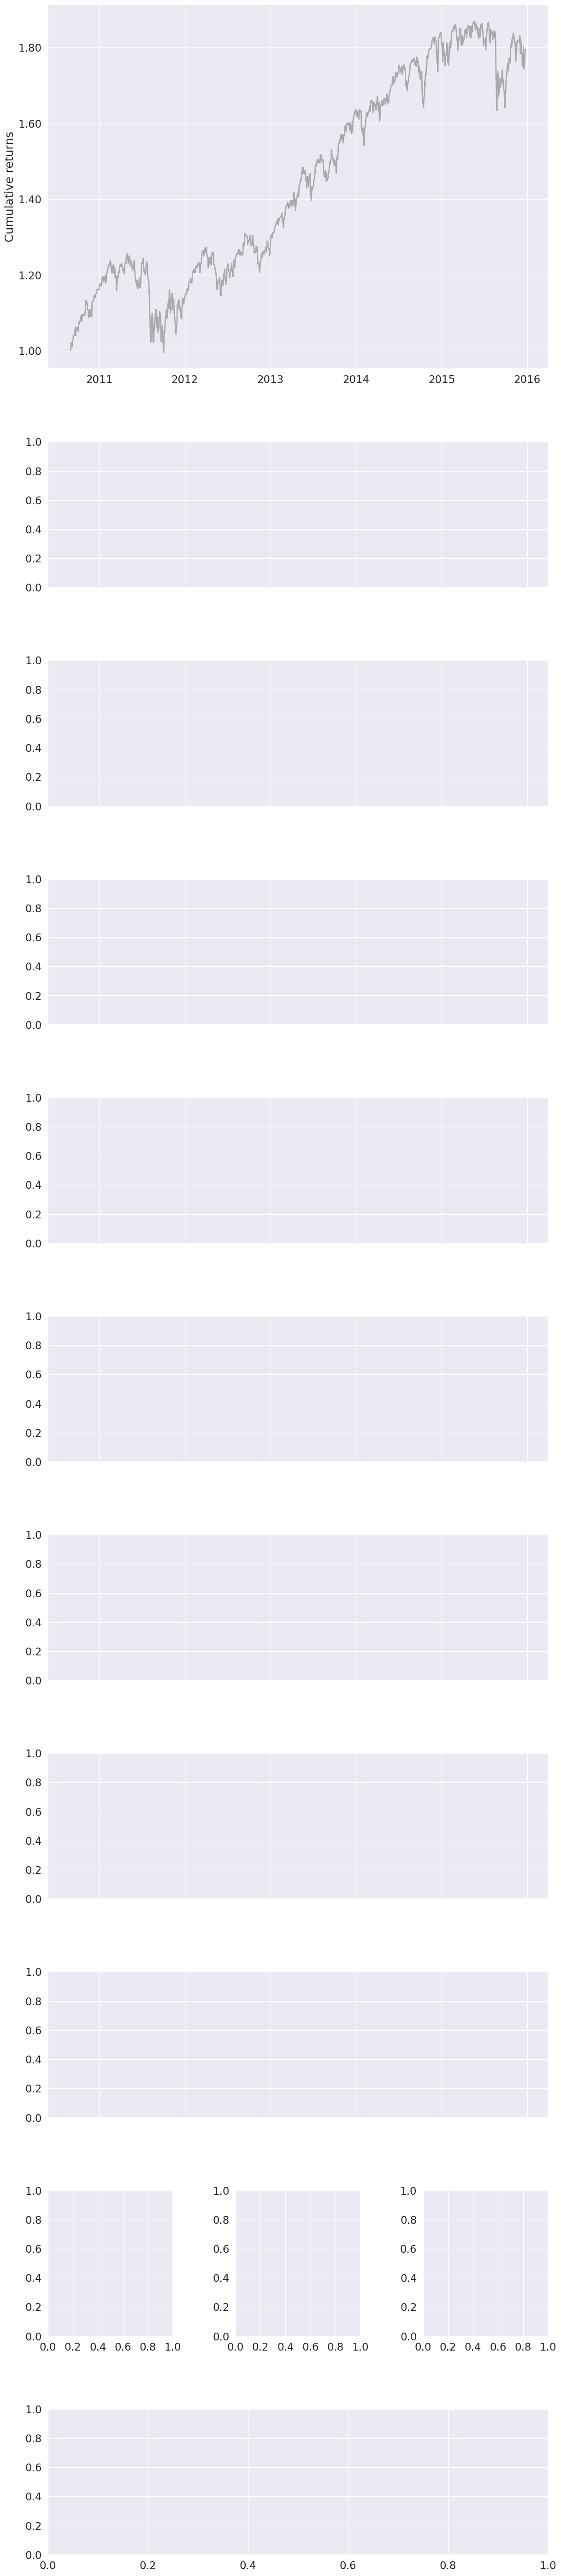

In [27]:
py.create_full_tear_sheet(stock_data['Portfolio_Value_rets'], benchmark_rets = benchmark_data['benchmark_rets'], live_start_date = live_date)